In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

import os, sys
lib_path = os.path.abspath(os.path.join('../'))
sys.path.append(lib_path)

import make_plots
import helpers

In [2]:
rootpath = '/home/taylor/Documents/Research/spitzer/'
planet = 'MASCARA1b'
channel = 'ch2'

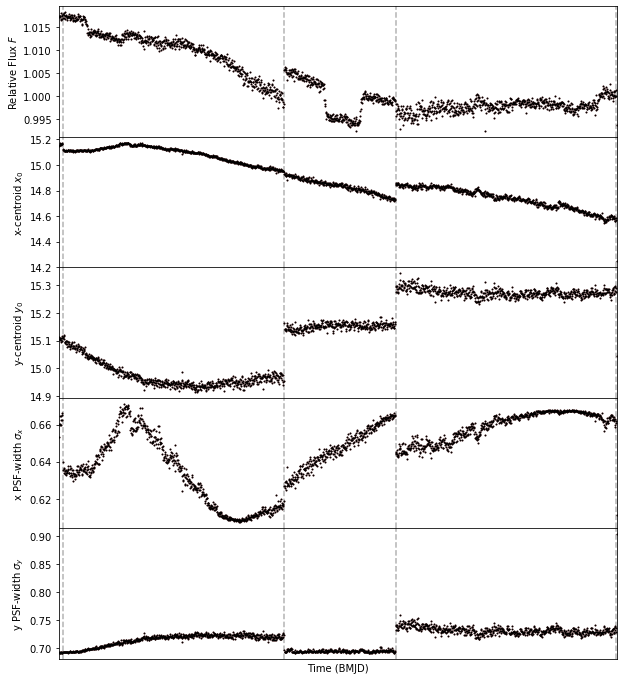

Would you like to cut the first AOR (y/n)? y


In [8]:
AOR_snip = ''
with open(rootpath+planet+'/analysis/aorSnippet.txt') as f:
    AOR_snip = f.readline().strip()[1:]

mainpath   = rootpath+planet+'/analysis/'+channel+'/'
phoption = ''
ignoreFrames = np.array([])
rms = None
with open(mainpath+'bestPhOption.txt') as f:
    lines = f.readlines()
    for i in range(len(lines)):
        if phoption=='' and lines[i][0]=='/':
            foldername = rootpath+lines[i][lines[i].find(planet):].strip()+'/'
            phoption = lines[i].split('/')[-1].strip()
            i += 1
            ignoreFrames = np.array(lines[i].strip().split('=')[1].replace(' ','').split(','))
            if np.all(ignoreFrames==['']):
                ignoreFrames = np.array([]).astype(int)
            else:
                ignoreFrames = ignoreFrames.astype(int)
            i += 1
            rms = float(lines[i])
        elif phoption!='' and lines[i][0]=='/':
            if float(lines[i+2]) < rms:
                foldername = rootpath+lines[i][lines[i].find(planet):].strip()+'/'
                phoption = lines[i].split('/')[-1].strip()
                i += 1
                ignoreFrames = np.array(lines[i].split('=')[1].replace(' ','').split(','))
                if np.all(ignoreFrames==['']):
                    ignoreFrames = np.array([]).astype(int)
                else:
                    ignoreFrames = ignoreFrames.astype(int)
                i += 1
                rms = float(lines[i])
            else:
                i += 3
                
aors = os.listdir(rootpath+planet+'/data/'+channel)
aors = np.sort([aor for aor in aors if AOR_snip==aor[1:1+len(AOR_snip)]])
    
breaks = []
for aor in aors[1:]:
    rawfiles = np.sort(os.listdir(rootpath+planet+'/data/'+channel+'/'+aor+'/'+channel+'/bcd/'))
    rawfiles  = [rawfile for rawfile in rawfiles if '_bcd.fits' in rawfile]
    rawImage = fits.open(rootpath+planet+'/data/'+channel+'/'+aor+'/'+channel+'/bcd/'+rawfiles[0])

    # Get the time of the first exposure of each AOR after the first
    #     - this allows us to plot dashed lines where AOR breaks happen and where jump discontinuities happen
    breaks.append(rawImage[0].header['BMJD_OBS'] + rawImage[0].header['FRAMTIME']/2/3600/24)

filename   = channel + '_datacube_binned_AORs'+AOR_snip+'.dat'
data = helpers.get_data(foldername+filename)
# Sort data
flux, flux_err, time, xdata, ydata, psfxw, psfyw = helpers.time_sort_data(*data)

# Make the plots
make_plots.plot_photometry(time, flux, xdata, ydata, psfxw, psfyw, 
                           time, flux, xdata, ydata, psfxw, psfyw, breaks)

response = input('Would you like to cut the first AOR (y/n)? ')

if response=='y':
    cutFirstAOR = True
else:
    cutFirstAOR = False
    
with open(rootpath+planet+'/analysis/cutFirstAOR.txt', 'w') as f:
    f.write(str(cutFirstAOR))